In [1]:
# imports

from torchvision import transforms
from torchinfo import summary
from torch import hub, device, cuda, load, Tensor, nn, cat, from_numpy, argmax, mean
import torch
from torch.utils.data import DataLoader
from timm.data import resolve_model_data_config, create_transform

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import pickle
import numpy as np
import os
import csv
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from collections import OrderedDict
import sys
sys.path.append(r'/home/stud/afroehli/coding/util_scripts')
from utils_dataloading.imagenet_tree import ImagenetSemanticInfo, ImagenetSemanticSubtree

device = device('cuda' if cuda.is_available() else 'cpu')
print(f'Device used: {device}')

/home/stud/afroehli/miniconda3/envs/dinov2Pre/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device used: cuda


In [2]:
# util objects

imagenet_info = ImagenetSemanticInfo()

Stop node discovered


In [3]:
with open('/home/stud/afroehli/datasets/imagenet_v2_label_transform/imagenet_1k_label_order.txt', 'r') as label_order_file:
    inet_1k_labels = label_order_file.readlines()
    inet_1k_labels = [label_order_line.split()[0] for label_order_line in inet_1k_labels]

In [11]:
class_a_b_map = dict()

with open('/home/stud/afroehli/coding/dinov2_ood/storage/class_a_class_b_timm_trans.csv', 'r') as class_split_table:
    closest_pairs_timm_trans = csv.reader(class_split_table, delimiter=';')

    for class_a, class_b in closest_pairs_timm_trans:
        class_a_b_map[class_a] = class_b

In [4]:
# load model

pretr_head = load('/home/stud/afroehli/coding/dinov2_ood/pretrained_heads/dinov2_vits14_linear_head.pth')
pretr_head_big = load('/home/stud/afroehli/coding/dinov2_ood/pretrained_heads/dinov2_vits14_linear4_head.pth')

/tmp/ipykernel_333255/2504633664.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretr_head = load('/home/stud/afroehli/coding/dinov2_ood/pretrained_heads/dinov2_vits14_

In [5]:
from torch import nn

class LinearClassifier(nn.Module): 

    def __init__(self, in_features = 384, out_features = 1000):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(in_features= in_features, out_features=out_features),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return cat((self.network.forward(x), self.network[0](x)))

    # def forward(self, x):
    #     return self.network(x)
    

In [6]:
# DataSet for training LinearClassifier
# custom dataset: dictonary -> [(embedding, index_as_tensor)]

class DictionaryDataset(torch.utils.data.Dataset): 
    
    """
    Pararms:
    1) data: complete dataset provided as dict
    2) index_list: list of data_dict-keys, order of keys in list will be used to create a tensor as the expected model-output
    """

    def __init__(self, data: dict, index_list: list[str]): 
        self.data_dict = data
        self.index_list = index_list 
        self.wnid_list = list(self.data_dict.keys())
        self.wnid_iterator = iter(self.wnid_list)
        self.instance_per_wnid = [len(self.data_dict[key]) for key in self.wnid_list]

    def __len__(self) -> int: 
        total_len = 0 
        for key in self.wnid_list:
            total_len += len(self.data_dict[key])

        return total_len 
    
    def __getitem__(self, idx) -> tuple[torch.Tensor, torch.Tensor]: 

        sum_instances = 0
        sum_rest = 0

        # start with first wnid in list
        new_wnid = ''

        # iterate until total of all already covered instances is bigger than index of interest
        # when class of interest is reached, condition will be false (sum_instances points to first element of next class)
        for wnid in self.wnid_list: 
            if sum_instances > idx:
                break 
            new_wnid = wnid 
            sum_rest = sum_instances 
            sum_instances += len(self.data_dict[wnid])

        # index within class is needed 
        # fixed order: [class1, class2, ...]
        # when lenght of each previously covered class is known, index within class of interest can be calculated 
        # sum_rest always represent the total of instances of all covered classes yet, not of interest
        idx_within_class = idx - sum_rest

        np_arr = self.data_dict[new_wnid][idx_within_class]
        data_tensor = torch.tensor(np.array(np_arr))

        label_tensor = torch.zeros(len(self.index_list))
        # put a one at the position for the expected class 
        label_tensor[self.index_list.index(new_wnid)] = 1 

        return data_tensor, label_tensor

In [7]:
# create all needed dataloaders

dataloaders_dict = dict()

for loader_name, loader_path in [('inet_1k_val', '/home/stud/afroehli/coding/model_results/dinov2_vits14/inet_1k_val_pt_timm_trans.pkl'),
                                 ('inet_r', '/home/stud/afroehli/coding/model_results/dinov2_vits14/inet_r_plus_pt_timm_trans.pkl'),
                                 ('inet_v2_70', '/home/stud/afroehli/coding/model_results/dinov2_vits14/inet_v2_70_plus_pt_timm_trans.pkl'),
                                 ('inet_v2_mf', '/home/stud/afroehli/coding/model_results/dinov2_vits14/inet_v2_mf_plus_pt_timm_trans.pkl'),
                                 ('inet_v2_top', '/home/stud/afroehli/coding/model_results/dinov2_vits14/inet_v2_top_plus_pt_timm_trans.pkl')]:
    
    with open(loader_path, 'rb') as pkl_fl:
        dataloaders_dict[loader_name] = DataLoader(dataset=DictionaryDataset(data=pickle.load(pkl_fl), index_list=inet_1k_labels), 
                                                   batch_size=128, shuffle=False, num_workers=8, pin_memory=True)



In [9]:
dataloaders_inet_c = dict()

src_path = '/home/stud/afroehli/coding/model_results/dinov2_vits14/imagenet_c'
inet_c_cor_types = os.listdir(src_path)

for cor_type in inet_c_cor_types:
    for sev in range(1, 6):
        with open(f'{src_path}/{cor_type}/sev_{sev}.pkl', 'rb') as pkl_fl: 
            if sev == 1:
                dataloaders_inet_c[cor_type] = dict()
            dataloaders_inet_c[cor_type][sev] = DataLoader(dataset=DictionaryDataset(pickle.load(pkl_fl), inet_1k_labels), 
                                                           batch_size=128, shuffle=False, num_workers=8, pin_memory=True) 

In [8]:
# helper function 
# takes: model and list of dataloaders
# returns: accuracy for each dataloader

def cls_with_patch_one_layer(batch_samples: torch.Tensor) -> torch.Tensor:
    return cat([cat((batch_sample[3][1].squeeze(), batch_sample[3][0].squeeze())).unsqueeze(0)
                                            for batch_sample in batch_samples])

def cls_with_patch_one_layer_inet_c(batch_samples: torch.Tensor) -> torch.Tensor: 
    return cat([cat((batch_sample[1].squeeze(), batch_sample[0].squeeze())).unsqueeze(0) for batch_sample in batch_samples])

def cls_without_patch_one_layer(batch_samples: torch.Tensor) -> torch.Tensor: 
    return cat([batch_sample[3][1] for batch_sample in batch_samples])

def cls_with_patch_four_layers(batch_samples: torch.Tensor) -> torch.Tensor: 
    return cat([cat(((cat([cls_token for _, cls_token in batch_sample], dim=-1),
                    batch_sample[3][0])), dim=-1)
                    for batch_sample in batch_samples])

def calc_accuracy(model: torch.nn.Sequential, n_layers: int, with_patch: bool, dataloaders: list, is_inet_c_data: bool) -> list: 

    if n_layers == 1:
        if with_patch:
            sample_transform = cls_with_patch_one_layer 
            if is_inet_c_data:
                sample_transform = cls_with_patch_one_layer_inet_c 
        else:
            sample_transform = cls_without_patch_one_layer 
    elif n_layers == 4: 
        sample_transform = cls_with_patch_four_layers 

    if sample_transform == None:
        raise ValueError('SampleTransform function could not be defined')
    
    accuracies = []
    
    for dataloader in (pbar := tqdm(dataloaders, ncols=100)):
                  
        total_preds = 0
        total_preds_true = 0
        for batch_samples, batch_labels in dataloader: 
            batch_samples_dev = sample_transform(batch_samples).to(device)
            
            model_pred = model(batch_samples_dev).cpu()

            is_equal = model_pred.argmax(axis=1) == batch_labels.argmax(axis=1)
            total_preds += is_equal.shape[0]
            total_preds_true += is_equal.type(torch.float).sum().item()

        accuracies.append(total_preds_true / total_preds)

    return accuracies 
            

In [9]:
# definition of linear classifiers 

model_params_one_layer = OrderedDict()
model_params_four_layers = OrderedDict()
model_params_cls_token = OrderedDict()
model_params_one_layer['network.0.weight'] = pretr_head['weight']
model_params_one_layer['network.0.bias'] = pretr_head['bias']
model_params_cls_token['network.0.weight'] = pretr_head['weight'][:,0:384]
model_params_cls_token['network.0.bias'] = pretr_head['bias']
model_params_four_layers['network.0.weight'] = pretr_head_big['weight']
model_params_four_layers['network.0.bias'] = pretr_head_big['bias']

lc_one_layer = LinearClassifier(in_features=768, out_features=1000)
lc_cls_token = LinearClassifier(in_features=384, out_features=1000)
lc_four_layer = LinearClassifier(in_features=1920, out_features=1000)

lc_one_layer.load_state_dict(model_params_one_layer)
lc_cls_token.load_state_dict(model_params_cls_token)
lc_four_layer.load_state_dict(model_params_four_layers)

lc_one_layer.eval()
lc_cls_token.eval()
lc_four_layer.eval()

lc_one_layer.to(device)
lc_cls_token.to(device)
lc_four_layer.to(device)

LinearClassifier(
  (network): Sequential(
    (0): Linear(in_features=1920, out_features=1000, bias=True)
    (1): Softmax(dim=1)
  )
)

In [12]:
# create tensor with length 1000, set a 1 when this is the label place of a class of class-a 

class_a_tensor = torch.zeros(len(inet_1k_labels))

for class_a_wnid in class_a_b_map.keys():
    pos = inet_1k_labels.index(class_a_wnid)
    class_a_tensor[pos] = 1

In [13]:
# takes a classification model and a dataloader
# calculate mean soft-max and mean logit for each Imagenet-1k class 

def calc_mean_lin_cl_res_per_class(model: nn.Sequential, d_loader: DataLoader,
                                relevant_classes: torch.tensor, model_type: str) -> tuple[dict, dict]: 

    mean_smax_per_class = dict()
    mean_logit_per_class = dict()
    samples_per_class = dict()

    if model_type == 'one_layer':
        input_transform = cls_with_patch_one_layer
    elif model_type == 'cls_token':
        input_transform = cls_without_patch_one_layer
    else:
        raise ValueError('No such model-type defined')
    
    with torch.no_grad():
        for batch_samples, batch_labels in d_loader: 
            batch_samples = input_transform(batch_samples).to(device)

            smax_and_logit_out = model(batch_samples)

            for n, label in enumerate(batch_labels):
                if torch.logical_and(label, relevant_classes).nonzero().numel():
                    label_index = label.argmax().item() 
                    assert type(label_index) == int
                    relevant_class_wnid = inet_1k_labels[label_index]
                    smax_val = smax_and_logit_out[n].cpu().detach().numpy()
                    logit_val = smax_and_logit_out[n + batch_labels.shape[0]].cpu().detach().numpy()
                    try:
                        mean_smax_per_class[relevant_class_wnid] = mean_smax_per_class[relevant_class_wnid] + np.array(smax_val)
                        mean_logit_per_class[relevant_class_wnid] = mean_logit_per_class[relevant_class_wnid] + np.array(logit_val)
                        samples_per_class[relevant_class_wnid] += 1
                    except KeyError:
                        mean_smax_per_class[relevant_class_wnid] = np.array(smax_val)
                        mean_logit_per_class[relevant_class_wnid] = np.array(logit_val)
                        samples_per_class[relevant_class_wnid] = 1

    for wnid in samples_per_class.keys():
        mean_smax_per_class[wnid] = mean_smax_per_class[wnid] / samples_per_class[wnid]
        mean_logit_per_class[wnid] = mean_logit_per_class[wnid] / samples_per_class[wnid]

        
    return mean_smax_per_class, mean_logit_per_class 

In [14]:
mean_smax_classes_a_lc_one, mean_logit_classes_a_lc_one = calc_mean_lin_cl_res_per_class(lc_one_layer, dataloaders_dict['inet_1k_val'],
                                                                                         class_a_tensor, 'one_layer') 
mean_smax_classes_a_lc_cls, mean_logit_classes_a_lc_cls = calc_mean_lin_cl_res_per_class(lc_cls_token, dataloaders_dict['inet_1k_val'],
                                                                                         class_a_tensor, 'cls_token') 

In [15]:
logit_means_all_cls = [mean_logit_classes_a_lc_one, mean_logit_classes_a_lc_cls]
for logit_means_per_cl in logit_means_all_cls:
    for wnid in logit_means_per_cl.keys():
        logit_means_per_cl[wnid] = list(zip([ np_val.item() for np_val in logit_means_per_cl[wnid]], inet_1k_labels))
        logit_means_per_cl[wnid].sort(key=lambda x: x[0], reverse=True)



<class 'matplotlib.axes._axes.Axes'>
lc_one_layer: Number of classes with higher mean logit-value than class-b
[('l1_dist', 1370), ('count_dims_nearer', 1029), ('count_within_stddev', 2040), ('count_excl_within_stddev', 1526)]
lc_cls_token: Number of classes with higher mean logit-value than class-b
[('l1_dist', 3202), ('count_dims_nearer', 2252), ('count_within_stddev', 4423), ('count_excl_within_stddev', 1150)]


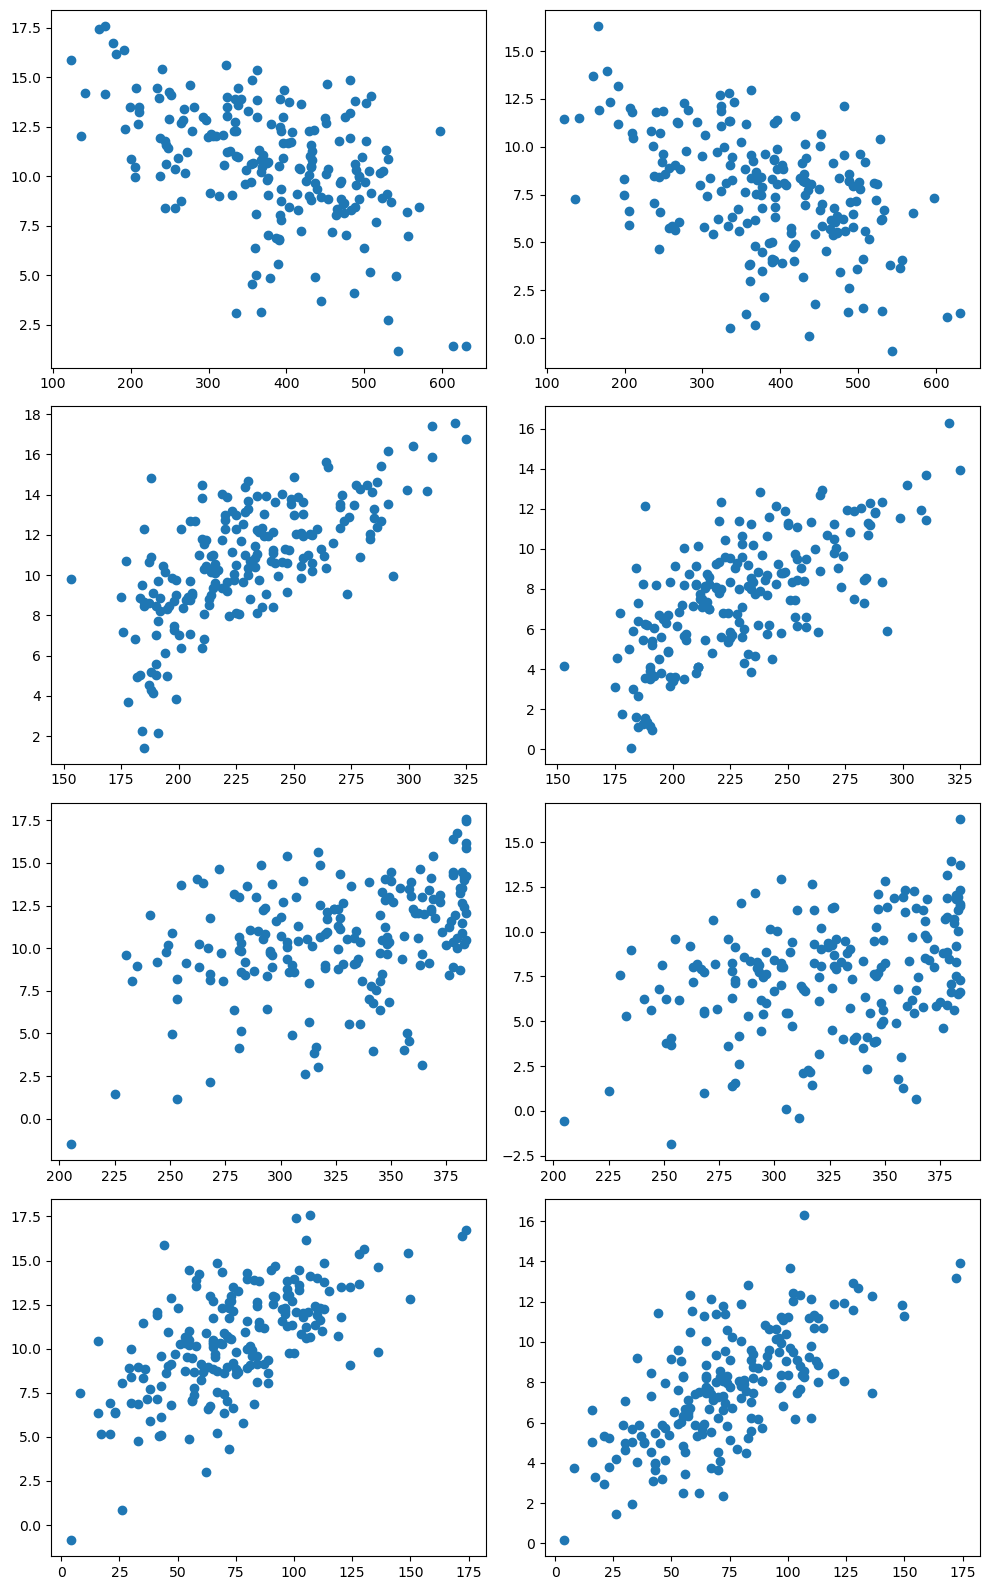

In [17]:
with open('/home/stud/afroehli/coding/dinov2_ood/storage/class_a_distances.pkl', 'rb') as pkl_fl: 
    class_a_distances = pickle.load(pkl_fl)

dfs_correlation = {'lc_one_layer': dict(), 'lc_cls_token': dict()}
dist_measure_performance = {'lc_one_layer': [], 'lc_cls_token': []}

logit_results_classifiers = [mean_logit_classes_a_lc_one, mean_logit_classes_a_lc_cls]
for cl_used, logit_res in zip(dfs_correlation.keys(), logit_means_all_cls):
    
    for dist_measure in class_a_distances.keys():
        data_df = []
        measure_deviations = 0 
        for class_a_wnid in logit_res.keys():
            class_b_per_dist_measure = class_a_distances[dist_measure][class_a_wnid][0][0]
            class_b_dist_measurement = class_a_distances[dist_measure][class_a_wnid][0][1]
            class_deviations = 0
            while logit_res[class_a_wnid][class_deviations][1] != class_b_per_dist_measure:
                class_deviations += 1 
            measure_deviations += class_deviations
            class_b_logit_val = logit_res[class_a_wnid][class_deviations][0]
            data_df.append((class_b_dist_measurement, class_b_logit_val))
        dist_measure_performance[cl_used].append((dist_measure, measure_deviations))
        dfs_correlation[cl_used][dist_measure] = pd.DataFrame(data=data_df, columns=['measurement_val', 'logit_val'])


# l1_df = dfs_correlation['l1_dist']
# l1_df['recp_val'] = 1 / l1_df['measurement_val']
# min_recp = l1_df['recp_val'].min()
# max_recp = l1_df['recp_val'].max()
# l1_df['recp_val_normalized'] = (l1_df['recp_val'] - min_recp) / (max_recp - min_recp)
# min_normal = l1_df['measurement_val'].min()
# max_normal = l1_df['measurement_val'].max()
# l1_df['measurement_val_normalized'] = (l1_df['measurement_val'] - min_normal) / (max_normal - min_normal)
# print(l1_df.head())

# sns.scatterplot(data=l1_df, x='measurement_val_normalized', y='logit_val')
# plt.show()
# sns.scatterplot(data=l1_df, x='recp_val_normalized', y='logit_val')
# plt.show()

fig, axs = plt.subplots(4, 2, figsize=(10, 16))
print(type(axs[0][0]))
for c, cl_used in enumerate(dfs_correlation.keys()):
    print(f'{cl_used}: Number of classes with higher mean logit-value than class-b')
    print(dist_measure_performance[cl_used])
    for r, dist_measure in enumerate(dfs_correlation[cl_used].keys()):
        # print(dist_measure)
        axs[r][c].scatter(data=dfs_correlation[cl_used][dist_measure], x='measurement_val', y='logit_val')
        
plt.tight_layout()
plt.savefig('/home/stud/afroehli/coding/dinov2_ood/diagrams_png/relation_distance_logit_val.png', bbox_inches='tight')
plt.show()

In [ ]:
# Calculate acc for each Imagenet-C Val dataset 

inet_c_accuracies = dict()
inet_c_dloader_list = []

for cor_type in dataloaders_inet_c.keys():
    for sev in dataloaders_inet_c[cor_type].keys():
        inet_c_dloader_list.append(dataloaders_inet_c[cor_type][sev])

inet_c_acc_list = calc_accuracy(lc_one_layer, 1, True, inet_c_dloader_list, is_inet_c_data=True)

acc_res_i = 0
for cor_type in dataloaders_inet_c.keys():
    for sev in dataloaders_inet_c[cor_type].keys():
        if sev == 1:
            inet_c_accuracies[cor_type] = dict()
        inet_c_accuracies[cor_type][sev] = inet_c_acc_list[acc_res_i]
        acc_res_i += 1 

with open('/home/stud/afroehli/coding/dinov2_ood/storage/lc_one_lay_pretr_inet_c_res.pkl', 'wb') as pkl_fl:
    pickle.dump(inet_c_accuracies, pkl_fl, pickle.HIGHEST_PROTOCOL)

100%|███████████████████████████████████████████████████████████████| 95/95 [11:30<00:00,  7.27s/it]


KeyError: 'spatter'

In [10]:
def get_corruption_type(cor_name: str) -> str:
    if cor_name in ['gaussian_noise', 'shot_noise', 'impulse_noise']:
        return 'noise'
    elif cor_name in ['defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur']:
        return 'blur'
    elif cor_name in ['snow', 'frost', 'brightness', 'fog']:
        return 'weather'
    elif cor_name in ['contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']:
        return 'digital'
    elif cor_name in ['speckle_noise', 'spatter', 'gaussian_blur', 'saturate']:
        return 'extra'
    else:
        return 'missing'

                        acc           cor_name
cor_name                                      
brightness         0.771428         brightness
contrast           0.659660           contrast
defocus_blur       0.534940       defocus_blur
elastic_transform  0.532520  elastic_transform
fog                0.657152                fog
  cor_name cor_type  sev      acc  mean_per_cor
0  spatter    extra    1  0.78862      0.732924
1  spatter    extra    2  0.75822      0.732924
2  spatter    extra    3  0.71746      0.732924
3  spatter    extra    4  0.72546      0.732924
4  spatter    extra    5  0.67486      0.732924


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, 'brightness'),
  Text(1, 0, 'fog'),
  Text(2, 0, 'snow'),
  Text(3, 0, 'frost'),
  Text(4, 0, 'impulse_noise'),
  Text(5, 0, 'gaussian_noise'),
  Text(6, 0, 'shot_noise'),
  Text(7, 0, 'saturate'),
  Text(8, 0, 'spatter'),
  Text(9, 0, 'speckle_noise'),
  Text(10, 0, 'gaussian_blur'),
  Text(11, 0, 'jpeg_compression'),
  Text(12, 0, 'contrast'),
  Text(13, 0, 'pixelate'),
  Text(14, 0, 'elastic_transform'),
  Text(15, 0, 'defocus_blur'),
  Text(16, 0, 'motion_blur'),
  Text(17, 0, 'zoom_blur'),
  Text(18, 0, 'glass_blur')])

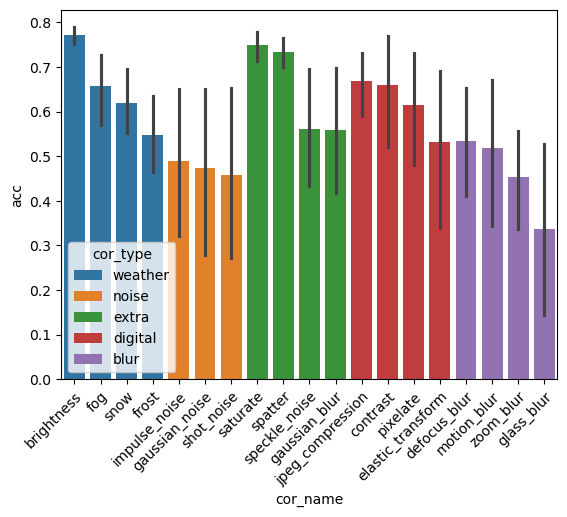

In [21]:
# visualize Imagenet-C accuracies

with open('/home/stud/afroehli/coding/dinov2_ood/storage/lc_one_lay_pretr_inet_c_res.pkl', 'rb') as pkl_fl:
    inet_c_accuracies = pickle.load(pkl_fl)

inet_c_acc_df_data = []

for cor_name in inet_c_accuracies.keys():
    for sev in inet_c_accuracies[cor_name].keys():
        cor_type = get_corruption_type(cor_name)
        inet_c_acc_df_data.append((cor_name, cor_type, sev, inet_c_accuracies[cor_name][sev]))

inet_c_acc_df = pd.DataFrame(data=inet_c_acc_df_data, columns=['cor_name', 'cor_type', 'sev', 'acc'])

# sort df by cor-type and then by acc-mean 
grouped_df = inet_c_acc_df.groupby('cor_name')['acc'].mean().to_frame()

grouped_df['cor_name'] = grouped_df.index 
print(grouped_df.head())
inet_c_acc_mean_per_cor_name = inet_c_acc_df['cor_name'].apply(lambda x: grouped_df[grouped_df['cor_name'] == x]['acc'].iloc[0])
inet_c_acc_df['mean_per_cor'] = inet_c_acc_mean_per_cor_name
print(inet_c_acc_df.head())

inet_c_acc_df = inet_c_acc_df.sort_values(['cor_type', 'mean_per_cor'], ascending=False)
sns.barplot(data=inet_c_acc_df, x='cor_name', y='acc', hue='cor_type')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')


In [14]:
# calculate accuracies 

dataloaders = [dataloaders_dict[loader_name] for loader_name in ['inet_v2_70', 'inet_v2_mf', 'inet_v2_top', 'inet_r', 'inet_1k_val']]

acc_dict = dict()

for layers, with_patch, lc_model, acc_name in [(1, True, lc_one_layer, 'acc_one_layer'),
                                              (1, False, lc_cls_token, 'acc_just_cls'),
                                              (4, True, lc_four_layer, 'acc_four_layers')]:
    
    acc_dict[acc_name] = calc_accuracy(lc_model, n_layers=layers, with_patch=with_patch, dataloaders=dataloaders)
    print(f'Acc for {acc_name}')
    print(acc_dict[acc_name])

100%|████████████████████████████████████████████████████████████| 391/391 [00:02<00:00, 136.11it/s]


Acc for acc_one_layer
[0.7969, 0.7277, 0.8326, 0.4062, 0.81774]


100%|████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 122.99it/s]


Acc for acc_just_cls
[0.7294, 0.6686, 0.7635, 0.42433333333333334, 0.74644]


100%|█████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 74.38it/s]

Acc for acc_four_layers
[0.7795, 0.7094, 0.8204, 0.3516, 0.80774]


In [12]:
# TODO: change sm-calculation to former version without logits, than visualize again

model_params_one_layer = OrderedDict()
model_params_four_layers = OrderedDict()
model_params_cls_token = OrderedDict()
model_params_one_layer['network.0.weight'] = pretr_head['weight']
model_params_one_layer['network.0.bias'] = pretr_head['bias']
model_params_cls_token['network.0.weight'] = pretr_head['weight'][:,0:384]
model_params_cls_token['network.0.bias'] = pretr_head['bias']
model_params_four_layers['network.0.weight'] = pretr_head_big['weight']
model_params_four_layers['network.0.bias'] = pretr_head_big['bias']

lc_one_layer = LinearClassifier(in_features=768, out_features=1000)
lc_cls_token = LinearClassifier(in_features=384, out_features=1000)
lc_four_layer = LinearClassifier(in_features=1920, out_features=1000)

lc_one_layer.load_state_dict(model_params_one_layer)
lc_cls_token.load_state_dict(model_params_cls_token)
lc_four_layer.load_state_dict(model_params_four_layers)

lc_one_layer.eval()
lc_cls_token.eval()
lc_four_layer.eval()

lc_one_layer.to(device)
lc_cls_token.to(device)
lc_four_layer.to(device)

acc_per_class = dict()

# for each lc calculate accuracy on INet-1k Val 

with torch.no_grad():
    for lc_model, lc_name in [(lc_one_layer, 'LC_ONE_LAYER'), (lc_cls_token, 'LC_CLS_TOKEN'), (lc_four_layer, 'LC_FOUR_LAYER')]:

        correct_preds = 0
        total_preds = 0
        pred_arr = []
        label_arr = []

        acc_per_class[lc_name] = dict()
        for class_a_wnid in class_a_b_map.keys():
            acc_per_class[lc_name][class_a_wnid] = {'true_pred': 0, 'total_pred': 0, 'acc': 0, 
                                                    'm_smax': np.zeros(1000), 'm_logits': np.zeros(1000)}

        for batch in inet_1k_pt_dataloader:
            
            batch_samples = batch[0]
            batch_labels = batch[1]
            if lc_name == 'LC_ONE_LAYER':
                batch_samples_dev = cat([cat((batch_sample[3][1].squeeze(), batch_sample[3][0].squeeze())).unsqueeze(0)
                                    for batch_sample in batch_samples]).to(device)
            elif lc_name == 'LC_CLS_TOKEN':
                batch_samples_dev = cat([batch_sample[3][1] for batch_sample in batch_samples]).to(device)
            elif lc_name == 'LC_FOUR_LAYER':
                batch_samples_dev = cat([cat(((cat([cls_token for _, cls_token in batch_sample], dim=-1),
                    batch_sample[3][0])), dim=-1)
                    for batch_sample in batch_samples]).to(device)
            else:
                raise ValueError(f'Name of lc not defined: {lc_name}')
            
            lc_sm_and_logit = lc_model(batch_samples_dev)
            lc_preds = lc_sm_and_logit[:int(lc_sm_and_logit.shape[0] / 2)]
            lc_preds = lc_preds.cpu()
            is_equal = batch_labels.argmax(axis=1) == lc_preds.argmax(axis=1) 
            correct_preds += is_equal.type(torch.float).sum().item()
            total_preds += is_equal.size(0)
            
            # detect class_a examples by label 
            n_samples = int(lc_sm_and_logit.shape[0] / 2)
            for i in range(0, n_samples):
                is_class_a = torch.logical_and(batch_labels[i, :], class_a_tensor).nonzero()
                if is_class_a.numel() == True:
                    matching_index = is_class_a[0].item()
                    matching_wnid = inet_1k_labels[matching_index]
                    if is_equal[i].item(): 
                        acc_per_class[lc_name][matching_wnid]['true_pred'] += 1
                    acc_per_class[lc_name][matching_wnid]['total_pred'] += 1
                    acc_per_class[lc_name][matching_wnid]['m_smax'] = acc_per_class[lc_name][matching_wnid]['m_smax'] + np.array(lc_preds[i])
                    acc_per_class[lc_name][matching_wnid]['m_logits'] = acc_per_class[lc_name][matching_wnid]['m_logits'] + np.array(lc_sm_and_logit[i + n_samples].cpu())

            pred_arr.append(lc_preds)
            label_arr.append(batch_labels)

        acc_model = correct_preds / total_preds 
        print(f'Accuracy of model {lc_name}: {acc_model}')

        for class_a_wnid in class_a_b_map.keys():
            acc_per_class[lc_name][class_a_wnid]['acc'] = float(acc_per_class[lc_name][class_a_wnid]['true_pred']) / 50
            acc_per_class[lc_name][class_a_wnid]['m_smax'] = acc_per_class[lc_name][class_a_wnid]['m_smax'] / 50
            acc_per_class[lc_name][class_a_wnid]['m_logits'] = acc_per_class[lc_name][class_a_wnid]['m_logits'] / 50
            
        #sk_acc = accuracy_score(label_arr, [p_acc.cpu() for p_acc in pred_arr], normalize=True)
        #print(f'SK acc: {sk_acc}')

Accuracy of model LC_ONE_LAYER: 0.81774
Accuracy of model LC_CLS_TOKEN: 0.74644
Accuracy of model LC_FOUR_LAYER: 0.80774


In [13]:
# for each class-a mean softmax 

# calculate diffs: L1-Dist = class-a -> class-b , SM-Dist = class-a -> nearest class not class-b 

diffs_distances = {'sm': dict(), 'logit': dict()}

wrong_max_sm = []

for class_a_wnid in class_a_b_map.keys():

    diffs_distances['sm'][class_a_wnid] = {'class_b_diff': [tuple], 'next_class_diff': [tuple]}
    diffs_distances['logit'][class_a_wnid] = {'class_b_diff': [tuple], 'next_class_diff': [tuple]}

    class_b_wnid = class_a_b_map[class_a_wnid]
    class_a_index = inet_1k_labels.index(class_a_wnid)
    class_b_index = inet_1k_labels.index(class_b_wnid)

    # calculate all sm-distances
    class_a_sm = acc_per_class['LC_ONE_LAYER'][class_a_wnid]['m_smax']
    class_a_sm_val = class_a_sm[inet_1k_labels.index(class_a_wnid)]
    sm_arr_class_a_val = np.array([class_a_sm_val for i in range(1000)])
    diff_to_class_a_val = np.subtract(sm_arr_class_a_val, class_a_sm) 

    # calculate all logit-distances 
    class_a_mean_logit = acc_per_class['LC_ONE_LAYER'][class_a_wnid]['m_logits']
    class_a_logit_val = class_a_mean_logit[inet_1k_labels.index(class_a_wnid)]
    class_a_upper_boundary_logit = np.array([class_a_logit_val for i in range(1000)])
    diff_to_class_a_logit = np.subtract(class_a_upper_boundary_logit, class_a_mean_logit)

    # class-b diff logit 
    diffs_distances['logit'][class_a_wnid]['class_b_diff'] = (class_b_wnid, diff_to_class_a_logit[class_b_index])

    # store sm-distance of class-b
    diffs_distances['sm'][class_a_wnid]['class_b_diff'] = (class_b_wnid, diff_to_class_a_val[class_b_index]) 

    # find next class with smalles sm-distance and store class + distance value
    min_diff_indices = np.argsort(diff_to_class_a_val)
    for min_diff_index in min_diff_indices:
        if not min_diff_index in [class_a_index, class_b_index]: 
            next_lowest_diff = diff_to_class_a_val[min_diff_index]
            next_class_wnid = inet_1k_labels[min_diff_index]
            diffs_distances['sm'][class_a_wnid]['next_class_diff'] = (next_class_wnid, next_lowest_diff)
            next_lowest_logit_diff = diff_to_class_a_logit[min_diff_index]
            diffs_distances['logit'][class_a_wnid]['next_class_diff'] = (next_class_wnid, next_lowest_logit_diff)
            break


In [14]:
# calculate l1-distances for class-b and next_nearest-class to class-a 

comp_l1_dists = dict()

with open('/home/stud/afroehli/coding/dinov2_ood/storage/class_a_b_next_nearest.csv', 'r') as csv_file:
    with open('/home/stud/afroehli/coding/model_results/dinov2_vits14/inet_1k_val_timm_trans.pkl', 'rb') as pkl_fl: 

        # all inet-1k-val embeddings
        inet_1k_val_res = pickle.load(pkl_fl)

        csv_reader = csv.reader(csv_file, delimiter=';')
        for n, (class_a_wnid, class_b_wnid, nn_class_wnid) in enumerate(csv_reader):
            # reject heading
            if n != 0: 
                class_a_mean_emb = np.mean(inet_1k_val_res[class_a_wnid], axis=0)
                class_b_mean_emb = np.mean(inet_1k_val_res[class_b_wnid], axis=0)
                nn_class_mean_emb = np.mean(inet_1k_val_res[nn_class_wnid], axis=0)


                comp_l1_dists[class_a_wnid] = {'class_b': np.sum(np.abs(class_a_mean_emb - class_b_mean_emb)), 
                                               'nn_class': np.sum(np.abs(class_a_mean_emb - nn_class_mean_emb))}
        

0.49748743718592964
0.7386934673366834


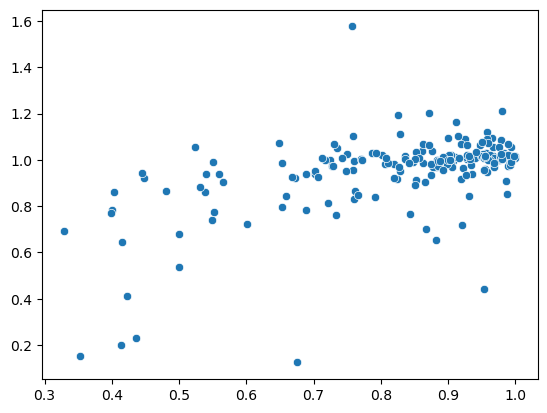

<Axes: >

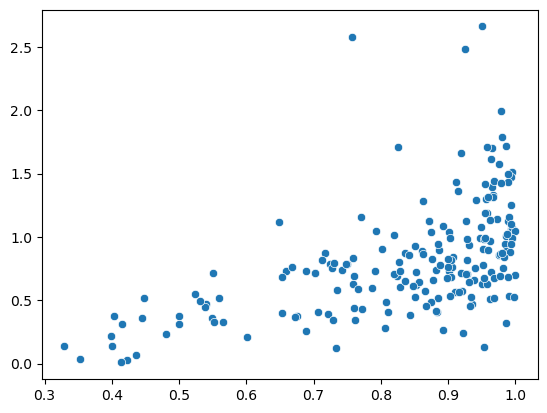

In [20]:
# draw distance relations: l1-distance / sm-distance

x_data = []
y_data = []
y_data_logit = []

y_max_1 = 0
y_max_1_logit = 0

for class_a in comp_l1_dists.keys():
    x_data.append((comp_l1_dists[class_a]['class_b'] / comp_l1_dists[class_a]['nn_class']).item())
    y_val = (diffs_distances['sm'][class_a]['class_b_diff'][1] / diffs_distances['sm'][class_a]['next_class_diff'][1]).item()
    y_data.append(y_val)
    y_val_logit = (diffs_distances['logit'][class_a]['class_b_diff'][1] / diffs_distances['logit'][class_a]['next_class_diff'][1]).item()
    y_data_logit.append(y_val_logit)
    if y_val < 1:
        y_max_1 += 1 
    if y_val_logit < 1: 
        y_max_1_logit += 1
    

print(y_max_1 / len(y_data))
print(y_max_1_logit / len(y_data))

sns.scatterplot(x=x_data, y=y_data)
plt.show()
sns.scatterplot(x=x_data, y=y_data_logit)

In [12]:
lc_one_layer_acc = []
lc_only_cls_acc = []
lc_four_layer_acc = []

for acc_list, lc_name in [(lc_one_layer_acc, 'LC_ONE_LAYER'), (lc_only_cls_acc, 'LC_CLS_TOKEN'), (lc_four_layer_acc, 'LC_FOUR_LAYER')]: 
    for class_a_wnid in class_a_b_map.keys():
        acc_list.append((acc_per_class[lc_name][class_a_wnid]['acc'], imagenet_info.wnid_to_classname[class_a_wnid]))

    print(lc_name)
    acc_list.sort(key=lambda x: x[0])
    print(acc_list)


LC_ONE_LAYER
[(0.38, ' bathtub'), (0.44, ' mushroom'), (0.52, ' Toy Poodle'), (0.54, ' vase'), (0.54, ' Bloodhound'), (0.58, ' backpack'), (0.58, ' Siberian Husky'), (0.6, ' Border Collie'), (0.6, ' cauldron'), (0.6, ' flute'), (0.62, ' missile'), (0.64, ' grasshopper'), (0.64, ' red fox'), (0.64, ' hatchet'), (0.64, ' bucket'), (0.64, ' assault rifle'), (0.64, ' cowboy hat'), (0.66, ' smooth newt'), (0.68, ' wine bottle'), (0.68, ' grand piano'), (0.7, ' candle'), (0.7, ' shield'), (0.7, ' tabby cat'), (0.7, ' hammer'), (0.72, ' spider web'), (0.72, ' espresso'), (0.72, ' pig'), (0.72, ' lighthouse'), (0.72, ' ambulance'), (0.74, ' electric guitar'), (0.74, ' lipstick'), (0.74, ' beer glass'), (0.76, ' tank'), (0.76, ' collie'), (0.76, ' Chihuahua'), (0.76, ' pickup truck'), (0.76, ' eel'), (0.78, ' German Shepherd Dog'), (0.78, ' violin'), (0.78, ' ice cream'), (0.78, ' Yorkshire Terrier'), (0.78, ' Shih Tzu'), (0.8, ' cucumber'), (0.8, ' tennis ball'), (0.8, ' lemon'), (0.8, ' Scott